In [1]:
from matplotlib import pyplot as plt
import numpy as np

Definition of constants

- `Nl` The total number of odorants

- `Nr` The number of receptors

- `K` The average number of odorants in the mixture

- `s` The probability that an odorant binds to a receptor


In [2]:
class BinaryEliminationSystem:

    ss_mat = None # Sparse Sensing Matrix
    ss_mat_index = None
    nl:int = 0 # total number of odorants
    nr:int = 0 # number of receptors
    k:int = 0 # average number of odorants in mixture
    s:float = 0 # probability that an odorant binds to a receptor
    odor_mat = None # generated odor inputs matrix (column major)
    rr = None; # receptor response matrix (column major)
    pred_odor_mat = None # predicted odor inputs (column major)


    def __init__(self, nl, nr, k, s):
        self.nl = nl
        self.nr = nr
        self.k = k
        self.s = s
        self.generate_ss_mat()


    def generate_ss_mat(self):
        """
        Generate a new sparce sensing matrix
        Args: 
        
        Returns:
            out (None): None
        """
        self.ss_mat = np.zeros((self.nr, self.nl), dtype=np.uint8)
        self.ss_mat_index = [[] for i in range(self.nr)]
        value = np.random.random((self.nr, self.nl)) < self.s
        for i in range(self.nr):
            for j in range(self.nl):
                if value[i, j]:
                    self.ss_mat[i, j] = 1;
                    self.ss_mat_index[i].append(j)
    

    def __generate_rand_odor(self, count):
        """
        Generate some odor vectors. Dimension of self.odor_mat will be (nl by count)
        Args: 
            count: Number of odor vectors to generate
        Returns:
            out (None): none
        """
        self.odor_mat = np.zeros((self.nl, count))
        for j in range(count):
            chosen = np.random.choice(self.nl, size=self.k, replace=False)
            for i in range(chosen.size):
                self.odor_mat[chosen[i], j] = 1
        
    
    def __get_rr(self):
        """
        Calculate the receptor response
        Args: 
            
        Returns:
            out (None): none
        """
        self.rr = np.dot(self.ss_mat, self.odor_mat)


    def encode_decode(self, count):
        """
        Calculate the receptor response
        Args: 
            
        Returns:
            out (None): none
        """
        self.__generate_rand_odor(count)
        self.__get_rr()
        self.pred_odor_mat = np.ones((self.nl, count), dtype=np.uint8)
        inactive_receptors = np.where(self.rr == 0)
        for i in range(len(inactive_receptors[0])):
            column = inactive_receptors[1][i]
            entry = inactive_receptors[0][i]
            result = self.pred_odor_mat[:, column] & (~self.ss_mat[entry, :])
            self.pred_odor_mat[:, column] = result.T


    def show_result(self):
        count = 0
        for i in range(self.odor_mat.shape[1]):
            if (np.array_equal(self.odor_mat.T[i, :], self.pred_odor_mat.T[i, :])):
                count += 1
        return count

250
260
270
280
290
300
310
320
330
340
350
360
370
380
390


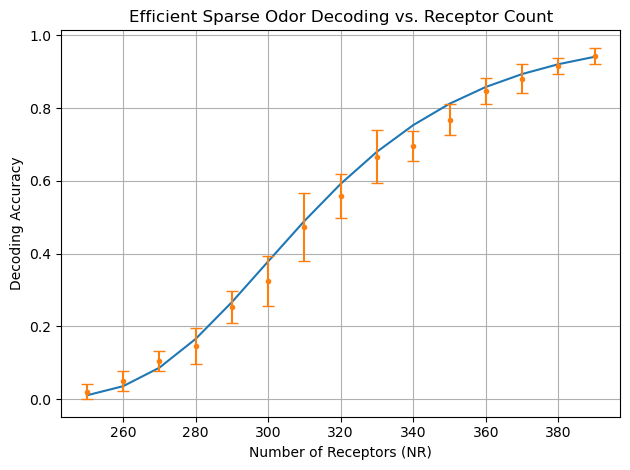

In [7]:
probs = []
mean_probs = []
errs = []
nr_values = np.arange(250, 400, 10)
for nr in nr_values:
    print(nr)
    trial_accuracies = np.zeros(10)
    a = BinaryEliminationSystem(10000, nr, 10, 0.05)
    for i in range(10):
        a.generate_ss_mat()
        a.encode_decode(100)
        correct = a.show_result()
        trial_accuracies[i] = correct / 100
    mean_probs.append(np.mean(trial_accuracies))
    errs.append(np.std(trial_accuracies))

# Plot
def estpc(Nr,k,s, NL):
    alpha = k/NL
    return (alpha+(1-alpha)*(1-(1-s*(1-s*alpha)**(NL-1))**Nr))**NL

plt.plot(nr_values,estpc(nr_values,10,0.05, 10000))
plt.errorbar(nr_values, mean_probs, yerr=errs, fmt='o', markersize=3, capsize=4)
plt.xlabel("Number of Receptors (NR)")
plt.ylabel("Decoding Accuracy")
plt.title("Efficient Sparse Odor Decoding vs. Receptor Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def phalf(s):
    return -(-4.61486830584+np.log(1/s))/s

NR = 1000
NL = 100000
k_vals = np.arange(1,50,1)
s_vals = np.linspace(0.01,0.1,49)
probs=np.zeros((49,49))
sNRs = []
ESTs = []

for i in range(len(s_vals)):
    sNRs.append(s_vals[i]*NR)
    ESTs.append(phalf(s_vals[i]))
    print(s_vals[i])
    for j in range(len(k_vals)):
        a = BinaryEliminationSystem(NL, NR, k_vals[j], s_vals[i])
        a.encode_decode(10)
        correct = a.show_result()
        probs[j][i] = correct / 10
        
plt.plot(sNRs, ESTs,color='w')
plt.contourf(sNRs, k_vals, probs, levels=50, cmap='viridis')
plt.colorbar(label='P(c=c)')
plt.xlabel('s*NR')
plt.ylabel('K')
plt.savefig("binary2")
plt.show()

0.01


Generate values for matrix **S** (receptor sensitivity to odorants)

- Dimension for `S` is `Nr` by `Nl`.

- Probability of an entry to be non-zero is `s`

- The non-zero entries are log-uniformly distributed between $10^{-1}$ and $10^1$